In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StringType,StructField, StructType, ArrayType
import json

In [2]:
spark = (SparkSession.builder.appName("ResumeProcessing")\
                    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.0').getOrCreate())

22/01/20 09:10:05 WARN Utils: Your hostname, djeinaba-HP-Laptop-15-bs1xx resolves to a loopback address: 127.0.0.1; using 10.11.7.230 instead (on interface wlo1)
22/01/20 09:10:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/djeinaba/Bureau/Classroom%20INSA%20EM/Classroom%20S9/Projet_s9/spark/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/djeinaba/.ivy2/cache
The jars for the packages stored in: /home/djeinaba/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-f28a369f-d83c-4da3-bbb7-3f5a628c0b44;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.2.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.2.0 in central
	found org.apache.kafka#kafka-clients;2.8.0 in local-m2-cache
	found org.lz4#lz4-java;1.7.1 in local-m2-cache
	found org.xerial.snappy#snappy-java;1.1.8.4 in central
	found org.slf4j#slf4j-api;1.7.30 in local-m2-cache
	found org.apache.hadoop#hadoop-client-runtime;3.3.1 in central
	found org.spark-project.spark#unused;1.0.0 in local-m2-cache
	found org.apache.hadoop#hadoop-client-api;3.3.1 in central
	found org.apache.htrace#htrace-core4;4.1.0-incubating in local-m2-cache
	found commons-logging#commons-logging;1.1.3 in local-m2-cache
	found co

In [3]:
df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "INDEED") \
    .option("startingOffsets","earliest") \
    .load()

In [4]:
df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [5]:
lines = df.selectExpr("CAST(value AS STRING)")

In [6]:
schema =StructType([StructField("companies", StringType(),True),
                           StructField("job_title", StringType(),True),
                           StructField("job_type",StringType(),True),
                           StructField("job_Description", StringType(),True),
                           StructField("job_link", StringType(),True),
                           ])

In [7]:
data_lines = lines.select(from_json(col("value"), schema).alias("data")).select("data.*")

In [8]:
data_agg_write_stream = data_lines \
        .writeStream \
        .trigger(processingTime='60 seconds') \
        .outputMode("append") \
        .option("truncate", "false") \
        .format("memory") \
        .queryName("jobPostTable") \
        .start()

data_agg_write_stream.awaitTermination(1)

22/01/20 09:10:32 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-7ba645e7-09e9-493d-9bf5-53654df96cf3. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
22/01/20 09:10:32 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


False

In [9]:
jobPosting_df = spark.sql('SELECT * FROM JobPostTable')

In [10]:
jobPosting_df.show()

+--------------------+--------------------+--------+--------------------+--------------------+
|           companies|           job_title|job_type|     job_Description|            job_link|
+--------------------+--------------------+--------+--------------------+--------------------+
|             Spotify|Summer Internship...|    None|Students\nWe are ...|https://www.indee...|
|           pulseData|Data Science Inte...|    None|pulseData is chan...|https://www.indee...|
|ZM Financial Systems|2021 Fall Interns...|    None|BREAKTHROUGH toge...|https://www.indee...|
|Major League Base...|2022 Summer Inter...|    None|The Major League ...|https://www.indee...|
|New York Life Ins...|NYL Data Scientis...|    None|A career at New Y...|https://www.indee...|
|              PayPal| Data Science Intern|    None|Who we are: At Pa...|https://www.indee...|
|             Quizlet|Database Reliabil...|    None|Inspired by our b...|https://www.indee...|
|Simpson Gumpertz ...|2022 Internship/C...|    Non

## Analyse de Mon CV et création de mon profil

### 1.Extraction du text du CV

In [11]:
import os
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd

In [12]:
file_path='/home/djeinaba/Bureau/my-resume.pdf'
my_resume = os.path.join(file_path)

In [13]:
from pdfminer.high_level import extract_text

def extract_text_from_pdf(pdf_path):
    return extract_text(pdf_path)

In [14]:
extracted_data=extract_text_from_pdf(os.path.join(file_path))

### 2.Création d'un dataframe contenant mes données

In [15]:
my_resume_data = pd.DataFrame(columns=["candidate_name", "text"])

In [16]:
my_resume_data["candidate_name"]=["Djeinaba"]
my_resume_data["text"]=[extracted_data]

In [17]:
my_resume_data["text"]

0    Profile\n\nDJEINABA BA\nStudent in Data \nEngi...
Name: text, dtype: object

### 3.Création du profil

In [18]:
from collections import Counter
import matplotlib.pyplot as plt

In [19]:
def create_profile(nlp, matcher,text,application_subject):
	# obtenir le matching pour les mots du text
	doc = nlp(text)
	matches = matcher(doc)
	
	
	d = []
	for match_id, start, end in matches:
		rule_id = nlp.vocab.strings[match_id]  #pour obtenir les compétences
		span = doc[start : end]  # pour obtenir les sous compétences
		d.append((rule_id, span.text))
	data = []
	for each,count in Counter(d).items():
		data.append([application_subject,*each,count])
	dataf = pd.DataFrame(data,columns=['Company/Candidate Name','Skill','Sub-skill','Count'])
	return(dataf)

In [20]:
def plot_df(final_database):
	"""
	This function simply plots the final
	plot for skill analysis
	And also saves the final png file
	:param final_database: dataframe of employees/JD and skills
	:output 1: saves a png file
	:output 2: saves a final excel sheet 
	"""

	final_database2 = final_database['Sub-skill'].groupby([final_database['Company/Candidate Name'], final_database['Skill']]).count().unstack()
	final_database2.reset_index(inplace = True)
	final_database2.fillna(0,inplace=True)
	new_data = final_database2.iloc[:,1:]
	new_data.index = final_database2['Company/Candidate Name']
	
	# Execute the below line if you want to see the JD profile in a csv format
	new_data.to_csv('skillset.csv')
	
	plt.rcParams.update({'font.size': 8	})
	ax = new_data.plot.barh(title="JD/Resume keywords by category", legend=True, figsize=(25,7), stacked=True)
	labels = []
	for j in new_data.columns:
		for i in new_data.index:
			label = str(j)+": " + str(new_data.loc[i][j])
			labels.append(label)
	patches = ax.patches
	for label, rect in zip(labels, patches):
		width = rect.get_width()
		if width > 0:
			x = rect.get_x()
			y = rect.get_y()
			height = rect.get_height()
			ax.text(x + width/2., y + height/2., label, ha='center', va='center')
	plt.savefig('graph.png')
	plt.show()

In [21]:
from spacy.matcher import PhraseMatcher

def init_parser_func(nlp, SKILL_FILE_PATH, file_type = 'csv'):


    if file_type == 'csv':
        keyword_ = pd.read_csv(SKILL_FILE_PATH)
    else:
        try:
            keyword_ = pd.read_excel(SKILL_FILE_PATH)
            print("Success!")
        except Exception as e:
            print(e)

    matcher = PhraseMatcher(nlp.vocab)
    for each in keyword_.columns: 
        matcher.add(each, None, *[nlp(text) for text in keyword_[each].dropna(axis = 0)])

    return matcher

In [22]:
import spacy
nlp = spacy.load('en_core_web_sm')

Success!


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 10.63it/s]


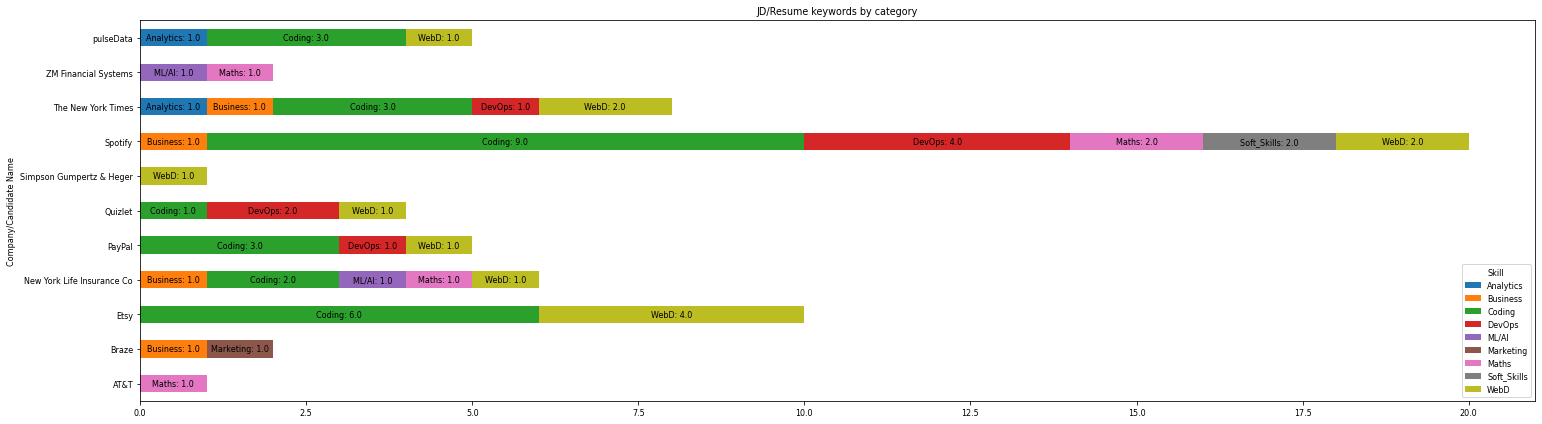

In [23]:
from tqdm import tqdm
SKILL_FILE_PATH = "Skillset.xlsx"

matcher = init_parser_func(nlp, SKILL_FILE_PATH, file_type="excel")

final_database = pd.DataFrame()
df = jobPosting_df.toPandas()


for each in tqdm(range(len(df))):

	text = df.loc[each,'job_Description']
	application_subject = df.loc[each,'companies']
	data = create_profile(nlp,matcher,text,application_subject)
	final_database = final_database.append(data)

	# Saving the database
final_database.to_csv('Data.csv', index=False)

# Plot the final figures
plot_df(final_database)
 

DataFrame[job_Description: string]